# Notebook for the ENS Challenge Data 2022 - Qube Research & Technologies 

# **Learning factors for stock market returns prediction**

### Data preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = '../' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

We have 50 stocks in the dataset and 754 days of returns for each stock.

In [2]:
X_train.shape

(50, 754)

In [3]:
X_train.head()

date,0,1,2,3,4,5,6,7,8,9,...,744,745,746,747,748,749,750,751,752,753
stocksID,,,,,,,,,,,,,,,,,,,,,
0,-0.018647,-0.013002,-0.010776,-0.016676,-0.005110,0.009092,-0.011745,0.007120,-0.008451,0.009119,...,-0.012525,-0.011716,0.003532,0.009965,0.018142,-0.001236,-0.002732,0.013074,-0.005843,-0.003823
1,-0.008254,-0.022280,0.012173,-0.006820,-0.004055,0.012912,-0.001293,0.009994,-0.002747,0.001664,...,0.014432,-0.002255,-0.011493,0.002291,-0.001346,-0.004026,-0.004672,-0.002889,-0.004984,0.005005
2,-0.008404,-0.013629,-0.006044,-0.003425,-0.009522,-0.001353,-0.000637,0.007640,0.001600,0.007416,...,-0.006245,-0.001329,0.005230,0.003510,0.006022,-0.000343,0.001757,0.004972,0.004916,-0.007338
3,-0.022734,-0.006981,-0.008568,-0.010899,-0.017981,0.002485,-0.011980,0.012446,-0.010636,0.003807,...,-0.005179,-0.003442,0.002733,0.013369,0.019738,0.001201,-0.003669,0.008690,0.000272,-0.008150
4,-0.024546,-0.008315,-0.007991,-0.003515,0.007872,0.007082,-0.004614,-0.008182,-0.005255,0.014404,...,-0.017507,-0.001233,-0.000552,0.004664,0.005202,0.007695,0.003775,0.005097,0.001135,-0.009262


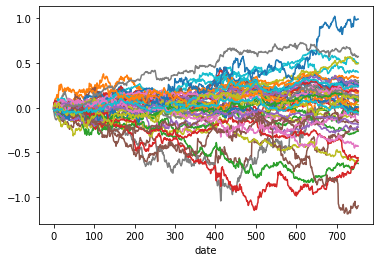

In [4]:
# The cumulative returns of the 50 stocks from the training data set over the three year period 

X_train.T.cumsum().plot(legend=False)
plt.show()

In [51]:
X_train.T.shape

(754, 50)

##### A useful data representation:

To speed up upcoming computations, we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

In [60]:
X_train_oneshift = pd.concat([X_train.T.shift(i+1).stack(dropna=False) for i in range(0,250)] ,1).dropna()
X_train_oneshift.shape

c:\Users\bensn\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


(25200, 250)

In [46]:
X_train_oneshift.shape

(36450, 25)

In [5]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(dropna=False) for i in range(250) ], 1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag')

c:\Users\bensn\anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


In [69]:
X_train_reshape[20][700]

-0.0027111869402541

The reason why the shape of this new datafram is (25200, 250) is because we have 754 days of returns for each stock and we have 50 stocks. So initially we have 754*50 = 37700 datapoints organised as 754 rows and 50 columns. We then calculate the lagged returns for the past 250 days and stack this data into a single column per day, hence the 250 rows in the final dataframe. We drop any rows with missing values so that is why the lagged returns begin at 250 days. (We can't calculate the lagged returns for the first 250 days because we don't have the returns for the 250 days prior to them!) We end up with $754-250 = 504$ rows of data for each stock, so we have $504*50 = 25200$ rows for each of the 250 lagged return columns. Hence the final dataframe's dimensions are (25200, 250). That's a whole lot of data!

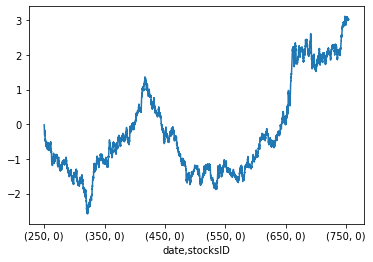

In [25]:
X_train_reshape[250].T.cumsum().plot(legend=False)
plt.show()

In [7]:
X_train_reshape.shape

(25200, 250)

In [8]:
X_train_reshape.head()

timeLag             1         2         3         4         5         6    \
date stocksID                                                               
250  0         0.000103  0.012387  0.011243  0.002595 -0.008509 -0.002711   
     1        -0.000982  0.003932  0.000050  0.001616 -0.003902 -0.001686   
     2         0.009301  0.003914  0.004995  0.001539  0.001452  0.002809   
     3         0.006515 -0.006553  0.009464  0.005204  0.004227 -0.005438   
     4        -0.006223  0.005415  0.014643  0.005195  0.004489  0.002695   

timeLag             7         8         9         10   ...       241  \
date stocksID                                          ...             
250  0         0.008934  0.006571 -0.018546 -0.008353  ...  0.009119   
     1         0.008810  0.001585 -0.000745 -0.002155  ...  0.001664   
     2         0.005177 -0.006942 -0.013340 -0.008071  ...  0.007416   
     3         0.008861  0.004025 -0.012432 -0.006100  ...  0.003807   
     4         0.007609  0.011437 -0.004804  0.039274  ...  0.014404   

timeLag             242       243       244       245       246       247  \
date stocksID                                                               
250  0        -0.008451  0.007120 -0.011745  0.009092 -0.005110 -0.016676   
     1        -0.002747  0.009994 -0.001293  0.012912 -0.004055 -0.006820   
     2         0.001600  0.007640 -0.000637 -0.001353 -0.009522 -0.003425   
     3        -0.010636  0.012446 -0.011980  0.002485 -0.017981 -0.010899   
     4        -0.005255 -0.008182 -0.004614  0.007082  0.007872 -0.003515   

timeLag             248       249       250  
date stocksID                                
250  0        -0.010776 -0.013002 -0.018647  
     1         0.012173 -0.022280 -0.008254  
     2        -0.006044 -0.013629 -0.008404  
     3        -0.008568 -0.006981 -0.022734  
     4        -0.007991 -0.008315 -0.024546  

[5 rows x 250 columns]

The motivation is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

# The prediction model

## Stiefel matrices

##### Example 1: autoregressive model AR(F)
Here we create an autographic model AR(F) with D=250 and F=10. The matrix only has values of 1 on the diagonal of the first F rows and 0 elsewhere.

In [9]:
def autoRegA(D=250, F=10):
    
    A = np.zeros((D,F))
    for i in range(F): 
        A[i,i] = 1
    return A

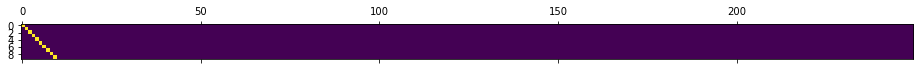

In [10]:
A = autoRegA()
plt.matshow(A.T)
plt.show()

##### Example 2: uniformly random Stiefel matrix A
Here we create a uniformly random Stiefel matrix A with D=250 and F=10. This just populates the matrix with random values between 

In [11]:
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return (randomStiefel, M)

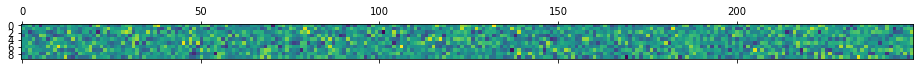

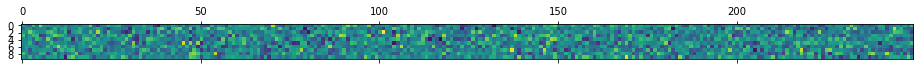

Min: -0.219 , Max: 0.192, Matrix norm: 3.162
Min: -3.073 , Max: 3.592, Matrix norm: 50.475


In [12]:
RandA, M = randomA()
plt.matshow(RandA.T)
plt.matshow(M.T)
plt.show()
print(f"Min: {round(RandA.min(),3)} , Max: {round(RandA.max(),3)}, Matrix norm: {round(np.linalg.norm(RandA),3)}")
print(f"Min: {round(M.min(),3)} , Max: {round(M.max(),3)}, Matrix norm: {round(np.linalg.norm(M),3)}")

In [13]:
# to check the orthonormality constraints as in the metric:
    
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    if any(Error.unstack() > 1e-6):
        bool = False
     
    return bool

In [14]:
checkOrthonormality(A)

True

## Beta parameters

##### Example 1: "keep the $m$ first factor only" 

In [15]:
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

In [16]:
beta = firstBeta()
beta

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

##### Example 2: given a Stiefel matrix A, return the beta with minimal mean square prediction error on the training data set

In [17]:
def fitBeta(A):
    "The @ symbol is the matrix multiplication operator in Python"
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    print(X_train_reshape.shape, A.shape, predictors.shape)
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
    
    return beta.to_numpy()

In [18]:
fitBeta(A)

(25200, 250) (250, 10) (25200, 10)


array([ 0.00623611, -0.00510036, -0.02025586, -0.00353405,  0.0088575 ,
        0.00473335,  0.01333769,  0.00205558, -0.00067165,  0.00917629])

## Metric on the training data set

The function **metric_train** below computes the *in sample* version of the metric for parameters 'A' and 'beta', using the accessible data sets 'X_train' and 'Y_train'. 

The true metric of the challenge is defined the same way except that we use the hidden data sets 'X_test' and 'Y_test' instead of 'X_train' and 'Y_train' (recall the latter contain the returns of 50 *other* stocks from the same stock market and on the *same* time period). 

In [19]:
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T         
    Ytrue = Y_train
    
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap  

# Examples

##### Test 1: The autoregressive model AR(10)
$$
S_{t+1} := \sum_{\ell=1}^{10} \beta_\ell R_{t+1-\ell}
$$
where the $\beta_\ell$'s are fitted by minimizing the mean square prediction error on the training data set. 

In [20]:
A = autoRegA()
beta = fitBeta(A)

metric_train(A, beta) # public metric: 0.01282

(25200, 250) (250, 10) (25200, 10)


0.02402799094688757

##### Test 2: The two factor model using '5-day returns' and 'momentum'
This model is suggested in the description of the challenge and reads
$$
S_{t+1} := \beta_1 \,R_t^{(5)} + \beta_2 \,R_{t-20}^{(230)},\qquad \text{ with }\quad R_t^{(m)}:= \frac1{\sqrt{m}}\sum_{k=1}^{m} R_{t+1-k},
$$
where we find the parameters $\beta_1$ and $\beta_2$ by minimizing the mean square prediction error on the training data set.  

*NB: the construction below actually shows how a model with $F\leq 10$ factors be recasted into the framework of the challenge.*

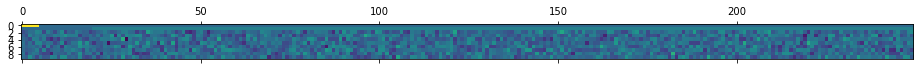

In [21]:
# Step 1: Create a 250x10 matrix A with the two first columns representing the factors of interest

A = np.zeros((250,10))

A[0:5, 0] = 1/np.sqrt(5) # 5-day return factor
A[20:250, 1] = 1/np.sqrt(230) # momentum factor

# Step 2: Fill the remaining columns of A with random orthonormal vectors, that are orthogonal to the two first columns

orthoProj = np.eye(250) - np.outer(A[:, 0], A[:, 0]) - np.outer(A[:, 1], A[:, 1]) # projection matrix on the orthogonal to the span of A[:,0] and A[:,1]
A_remaining_columns = orthoProj @ np.random.randn(250, 8) # sample random vectors in the space orthogonal to the first two columns of A
A_remaining_columns = np.linalg.qr(A_remaining_columns)[0] # orthonormalize these vectors with Gram-Schmidt algorithm
A[:, 2:] = A_remaining_columns
plt.matshow(A.T)
plt.show()

In [22]:


# Step 3: Compute the mean square optimal beta_1, beta_2 and then complete the vector beta with zeros

predictors = X_train_reshape @ A[:, :2]
targets = Y_train.T.stack()
beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
beta = np.hstack([beta, np.zeros(8)])
print(beta)


metric_train(A, beta) # public metric: 0.01787

[-0.00694934  0.01560642  0.          0.          0.          0.
  0.          0.          0.          0.        ]


0.019538512062321073

# The benchmark

This the code for the benchmark provided in the challenge description. 

In [23]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = randomA()
    beta = fitBeta(A)
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

ValueError: Dot product shape mismatch, (25200, 250) vs (2, 250, 10)

In [ ]:
metric_train(A_QRT, beta_QRT) # public metric: 0.03535

0.045787821873291355

# Postprocessing

## From $(A, \beta)$ to the output csv format

In [ ]:
def parametersTransform(A, beta, D=250, F=10):
    
    if A.shape != (D, F):
        print('A has not the good shape')
        return
    
    if beta.shape[0] != F:
        print('beta has not the good shape')
        return        
    
    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )
    
    return output

In [ ]:
# random submission example
np.random.seed(1234)

A = randomA()
beta = np.random.rand(10)

# from output to csv file...
output = parametersTransform(A, beta)
pd.DataFrame(output).to_csv(path + 'submissionExample.csv')

# ... and back
output_fromCsv = pd.read_csv(path + 'submissionExample.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))